In [1226]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from scipy.ndimage import zoom
from skimage import transform

In [1073]:
tpf = np.zeros((1000, 11, 11))

In [1074]:
tpf[:,4:7,4:7] = 200.0
tpf += 0

for i in range(1000):
    val = 200.0*i/len(tpf)
    tpf[i,4,4:7] -= val
    tpf[i,7,4:7] += val

In [1075]:
print(tpf[100,:,5])

[   0.    0.    0.    0.  180.  200.  200.   20.    0.    0.    0.]


In [1076]:
lc = np.sum(tpf, axis=(1,2))
yc = np.linspace(0, 1, 1000)
xc = np.zeros(1000)

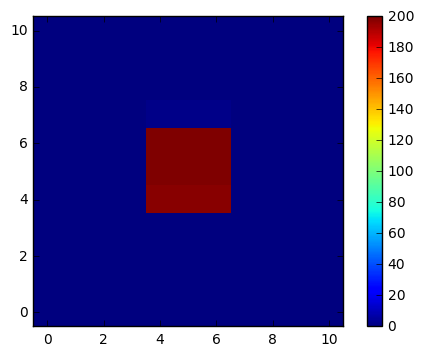

In [1077]:
plt.imshow(tpf[10], origin='lower', interpolation='nearest')
plt.colorbar()

In [1078]:
from scipy.interpolate import RectBivariateSpline

In [1079]:
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)

xp = np.linspace(0, 10, 44)
yp = np.linspace(0, 10, 44)

In [1080]:
#tpf = np.log(tpf)

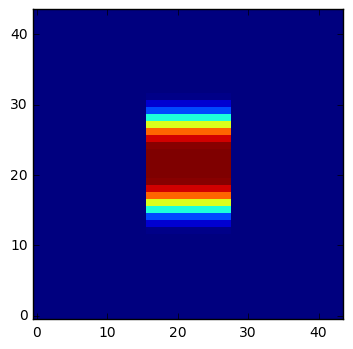

In [1257]:
super_tpf = [transform.resize(tpf[i], np.asarray(tpf[i].shape)*4, order=0) for i in range(1000)]
super_tpf = [shift(super_tpf[i], [-4.0*yc[i], -4.0*xc[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]

mean_super_tpf = np.mean(super_tpf, axis=0)
norm_super_tpf = mean_super_tpf / np.sum(mean_super_tpf)

plt.imshow(norm_super_tpf, origin='lower', interpolation='nearest')

In [1081]:
interp = [RectBivariateSpline(x, y, tpf[i], kx=1, ky=1) for i in range(tpf.shape[0])]


In [1092]:
super_tpf = np.array([interp[i](yp + (yc[i]), xp + (xc[i])) for i in range(len(xc))])

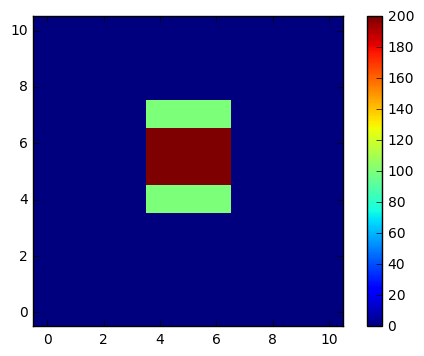

In [1093]:
plt.imshow(tpf[500], origin='lower', interpolation='nearest')
plt.colorbar()

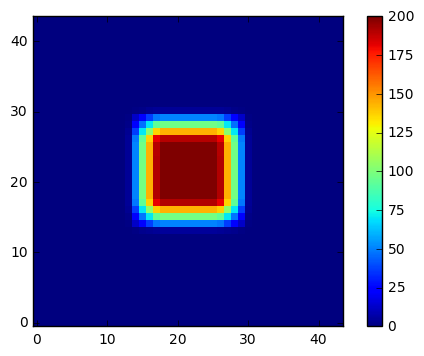

In [1094]:
plt.imshow(super_tpf[999], origin='lower', interpolation='nearest')
plt.colorbar()

In [1095]:
mean_super_tpf = np.mean(super_tpf, axis=0)

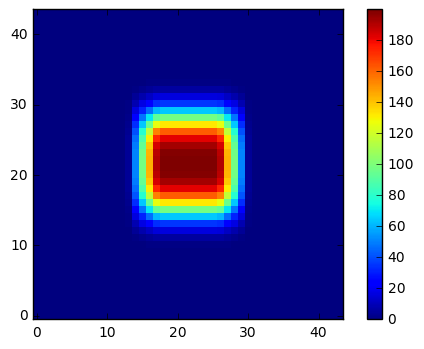

In [1096]:
plt.imshow(mean_super_tpf, origin='lower', interpolation='nearest')
plt.colorbar()

In [1097]:
norm_super_tpf = mean_super_tpf / np.sum(mean_super_tpf)

#norm_super_tpf = np.zeros((44,44))
#norm_super_tpf[16:28,16:28] = 1.0
#norm_super_tpf /= np.sum(norm_super_tpf)

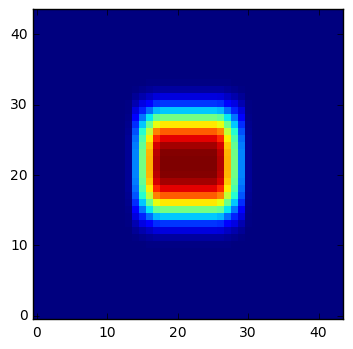

In [1098]:
plt.imshow(norm_super_tpf, origin='lower', interpolation='nearest')

In [1099]:
detector = np.ones((44,44))

In [1100]:
def model_prime(f, dy, dx, template):
    #interp_again = RectBivariateSpline(xp, yp, template, kx=1, ky=1)
    #return f * interp_again(yp - dy, xp - dx)
    interp_again = shift(template, [dy, dx], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
    return f * interp_again

In [1101]:
def model(f, dy, dx, template):
    tmp = model_prime(f, dy, dx, template).reshape(11, 4, 11, 4)
    return np.sum(tmp, axis=(1, 3))


In [1102]:
data = tpf[0]

In [1103]:
class lnlikelihood:
    def __init__(self, data):
        self.data = data
        
    def evaluate(self, p, template_s, template_d):
        f, dy, dx = p
        r = model(f, dy, dx, template_s)*model(1, 0, 0, template_d) + 1 - self.data
        return np.sum(r * r)

In [1104]:
from scipy.optimize import minimize
from tqdm import tqdm

print(np.shape(norm_super_tpf))

(44, 44)


In [1313]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(195, 0.001*i, 0.05), args=(norm_super_tpf, detector), method='Powell')
    #print(sol.fun)
    results.append(sol.x)
    lnlike.append(sol.fun)
    #print(lnlike)


100%|██████████| 1000/1000 [01:01<00:00, 16.19it/s]


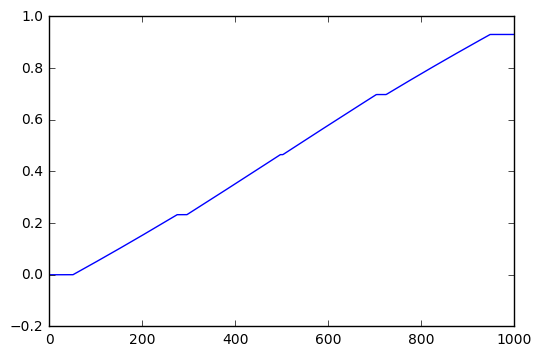

In [1314]:
results = np.array(results)
plt.plot(results[:,1])

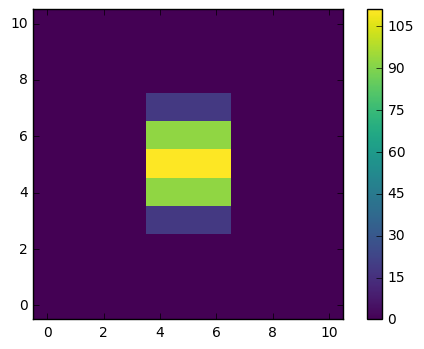

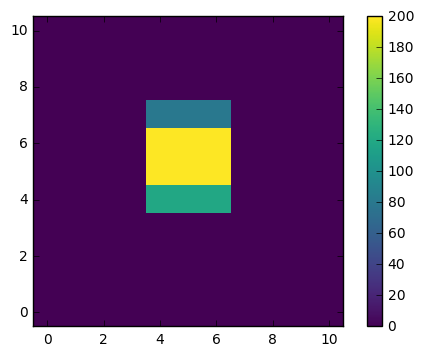

[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.30418088e+52   7.22597377e+86   7.22597377e+86   5.54062238e+34
   1.00000000e+00   1.00000000e+00   1.00000000e+00]
[   0.            0.            0.           18.53703704   92.62962963
  111.11111111   92.57407407   18.48148148    0.            0.            0.        ]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.00557277  0.00557277  0.00557277  0.00557277
  0.00557277  0.00557277  0.00557277  0.00557277  0.00557277  0.00557277
  0.00557277  0.00557277  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


In [1262]:
model_ = model(1000, 0.0, 0.0, norm_super_tpf)
#model_test = model(np.sum(tpf[-1]), results[-1][1], results[-1][2], norm_super_tpf)
plt.imshow(model_, origin='lower', interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.show()
#plt.imshow(mode, origin='lower', interpolation='nearest', cmap='viridis')
#plt.show()
plt.imshow(tpf[400], origin='lower', interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.show()

print(np.exp(tpf[400,:,5]))
print(model_[:,6])
print(norm_super_tpf[17])


In [1263]:
logL = lnlikelihood(data=tpf[400])
print(logL.evaluate((45.67, 1.6, 0.0), norm_super_tpf, detector))

184914.276478


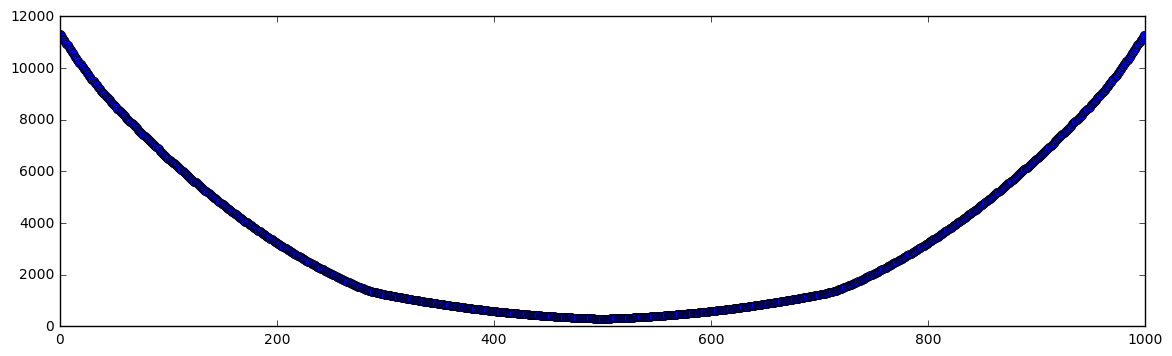

In [1264]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

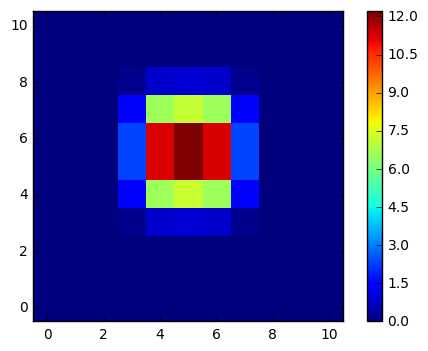

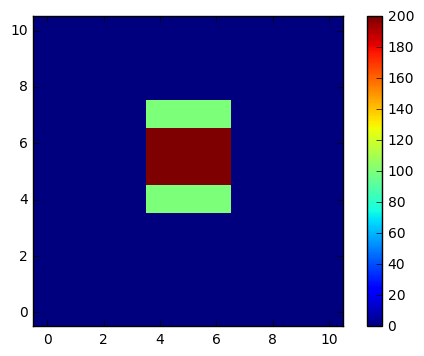

130.913979661
1800.0
[  1.13661534e+02   4.65116279e-01   1.18705215e-11]


In [1265]:
gds = norm_super_tpf
i = 500
plt.imshow(models[i], interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()
plt.imshow(tpf[i], interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()
print(np.sum(models[i]))
print(np.sum(tpf[i]))
print(results[500])

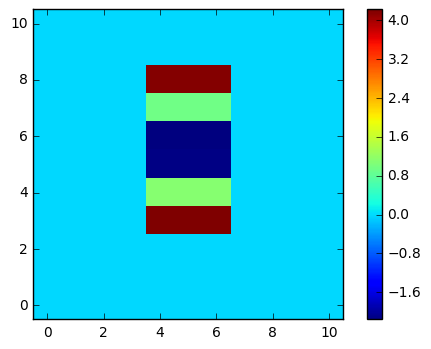

In [1286]:
models = [16*model(*results[i], norm_super_tpf) for i in range(1000)]

i = 500
plt.imshow(models[i] - tpf[i], interpolation='nearest', origin='lower')
plt.colorbar()
#interps = [RectBivariateSpline(x, y, models[i]*16 - tpf[i], kx=1, ky=1) for i in range(1000)]

resids = models - tpf

interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*4, order=0) for i in range(1000)]
interps = [shift(interps[i], [4.0*results[i,1], 4.0*results[i][2]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]


In [1287]:
#interp_ = RectBivariateSpline(x, y, model_ - tpf[0], kx=1, ky=1)

In [1288]:
dlnlike_ds = 2 * interps

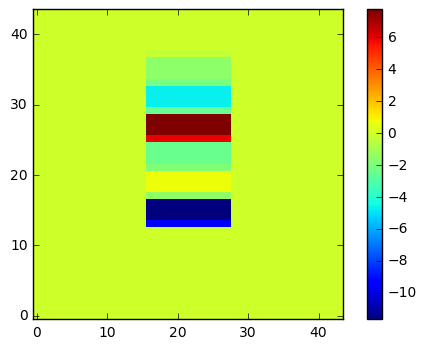

In [1289]:
plt.imshow(-dlnlike_ds[350], origin='lower', interpolation='nearest')
plt.colorbar()

In [1290]:
dlnlike_ds = np.sum(dlnlike_ds, axis=0)

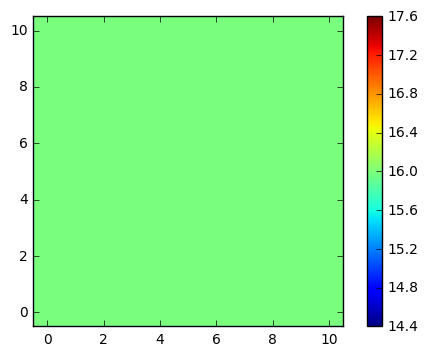

In [1168]:
plt.imshow(model(1, 0, 0, detector), origin='lower', interpolation='nearest')
plt.colorbar()

In [1169]:
#gds = np.copy(norm_super_tpf)

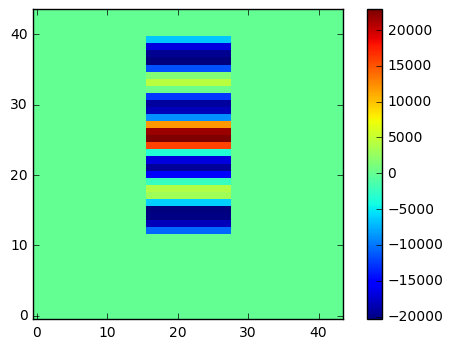

In [1291]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

In [1320]:
def gradient_descent_ds(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    yc_n = np.linspace(0, 1, 1000)
    j = 0
    c = 1e-10
    tmp_s = template_s
    models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s)*model(1, 0, 0, template_d) for i in range(1000)]
    resids = models - tpf
    interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*4, order=0) for i in range(1000)]
    interps = [shift(interps[i], [4.0*yc_n[i], 4.0*xc_n[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]

    dlnlike_ds = 2 * interps
    dlnlike_ds = np.sum(dlnlike_ds, axis=0)
    plt.imshow(-dlnlike_ds, interpolation='nearest', origin='lower')
    plt.colorbar()
    plt.show()
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                          for i in range(1000)])
    while j < 2000:
        tmp_s = tmp_s - c * dlnlike_ds
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                             for i in range(1000)])
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
            models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s)*model(1, 0, 0, template_d) for i in range(1000)]
            resids = models - tpf
            interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*4, order=0) for i in range(1000)]
            interps = [shift(interps[i], [4.0*yc_n[i], 4.0*xc_n[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]
            dlnlike_ds = 2 * interps
            dlnlike_ds = np.sum(dlnlike_ds, axis=0)
        else:
            c *= .25
        if c < 1e-16:
            break
        logL_before = logL_after
        j += 1
    return tmp_s

In [1294]:
def gradient_descent_dd(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-10
    tmp_d = template_d
    models = [model(f_n[i], yc_n[i], xc_n[i], template_s)*model(1, 0, 0, tmp_d) for i in range(1000)]
    resids = models - tpf
    interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*4, order=0) for i in range(1000)]
    
    dlnlike_dd = 2 * interps
    dlnlike_dd = np.sum(dlnlike_dd, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                              for i in range(1000)])
    while j < 2000:
        tmp_d = tmp_d - c * dlnlike_dd
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                             for i in range(1000)])
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
            models = [model(f_n[i], yc_n[i], xc_n[i], template_s)*model(1, 0, 0, tmp_d) for i in range(1000)]
            resids = models - tpf
            interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*4, order=0) for i in range(1000)]

            dlnlike_dd = 2 * interps
            dlnlike_dd = np.sum(dlnlike_dd, axis=0)
        else:
            c *= .25
        if c < 1e-14:
            break
        logL_before = logL_after
        j += 1
    return tmp_d

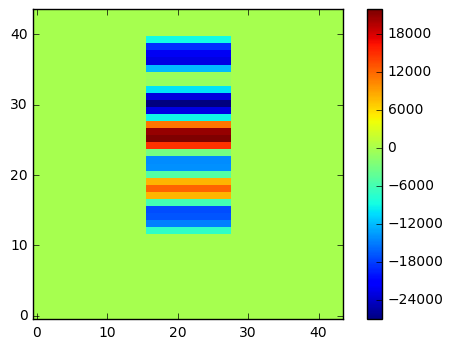

3679042.26706
3665974.01234
3665974.01234
3651678.07041
3651678.07041
3636047.60855
3636047.60855
3618968.23882
3618968.23882
3600317.85059
3600317.85059
3579966.52847
3579966.52847
3557776.57944
3557776.57944
3533602.69642
3533602.69642
3507292.28976
3507292.28976
3478686.02179
3478686.02179
3447618.58369
3447618.58369
3413919.75736
3413919.75736
3377415.80776
3377415.80776
3337931.25297
3337931.25297
3295291.05928
3295291.05928
3249323.30665
3249323.30665
3199862.36493
3199862.36493
3146752.61304
3146752.61304
3089852.72102
3089852.72102
3029040.49855
3029040.49855
2964218.29321
2964218.29321
2895318.89861
2895318.89861
2822311.90844
2822311.90844
2745210.43215
2745210.43215
2664078.07645
2664078.07645
2579036.10434
2579036.10434
2490270.72114
2490270.72114
2398040.52171
2398040.52171
2302684.2825
2302684.2825
2204629.51828
2204629.51828
2104402.56465
2104402.56465
2002641.41233
2002641.41233
1900113.11552
1900113.11552
1797738.32777
1797738.32777
1696626.38875
1696626.38875
1598125.

In [1321]:
results = np.array(results)
gds = gradient_descent_ds(norm_super_tpf, detector, (results[:, 0], results[:,1], results[:, 2]))


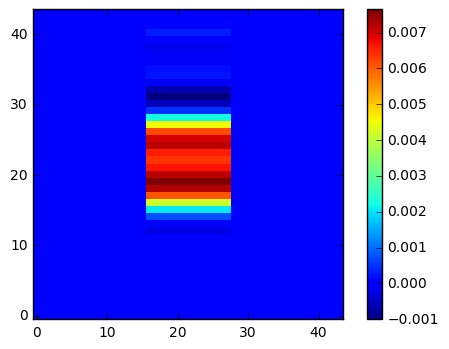

In [1322]:
plt.imshow(gds, origin='lower', interpolation='nearest')
plt.colorbar()

In [1323]:
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

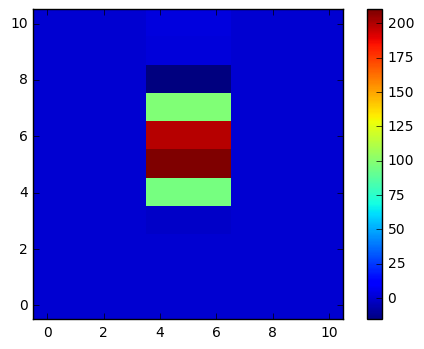

In [1326]:
n=500
plt.imshow(model(f_n[n], yc_n[n], xc_n[n], gds) * model(1, 0, 0, detector) + 1, origin='lower', interpolation='nearest')
plt.colorbar()

In [1327]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, detector), method='Powell')
    results.append(sol.x)
    lnlike.append(sol.fun)

100%|██████████| 1000/1000 [00:54<00:00, 17.90it/s]


In [1328]:
pred_flux = [np.sum(model(f_n[i], yc_n[i], xc_n[i], gds)*16) for i in range(1000)] 

(1500, 2000)

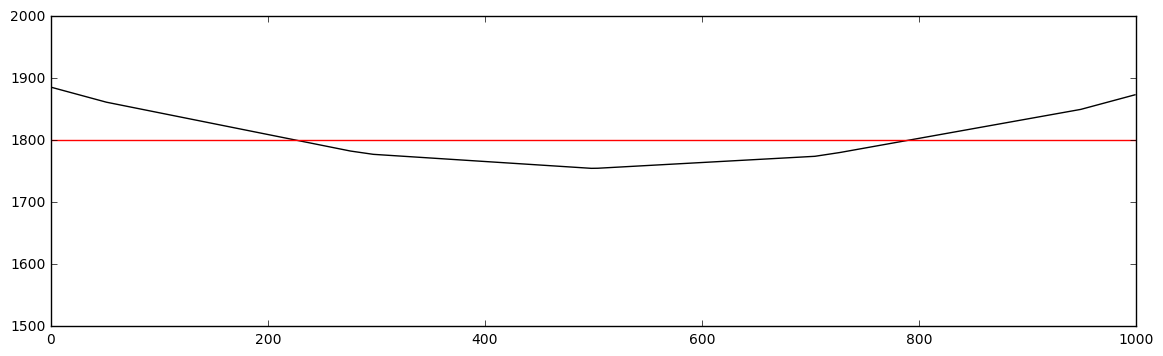

In [1329]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux, 'k')
plt.plot(np.arange(1000), np.sum(tpf, axis=(1,2)), 'r')
plt.ylim(1500, 2000)

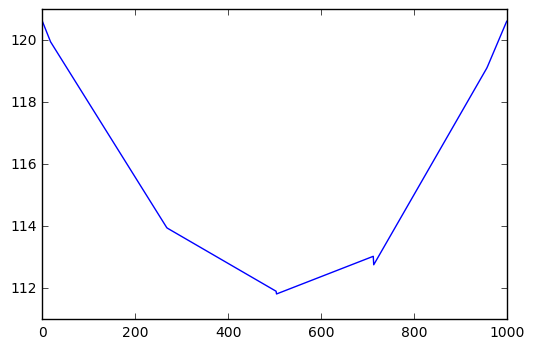

In [1332]:
results = np.array(results)
plt.plot(np.arange(1000), results[:,0])

1920.9999975547826

What have we learned? This works *perfectly* when the star is not moving. This is a good thing!
When the star is moving, this is not working perfectly. Need to trace down why and figure out how to stop it.

0


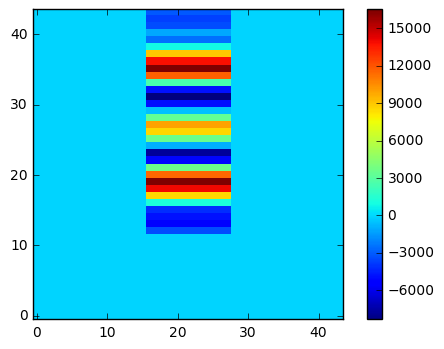

1130953.05356
1131422.40394
1131422.40394
1131541.88943
1131541.88943
1131571.89505
1131571.89505
1131579.40484
1131579.40484
1131581.28282
1131581.28282
1131581.75234
1131581.75234
1131581.86973
1131581.86973
1131581.89907
1131581.89907
1131581.90641
1131581.90641
1131581.90824


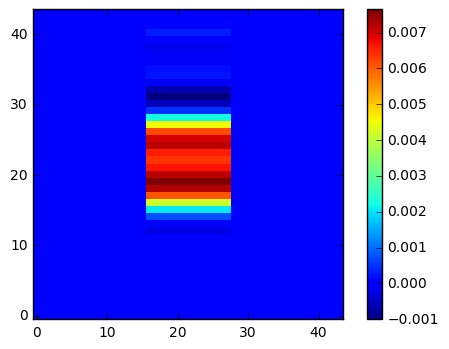

100%|██████████| 1000/1000 [00:18<00:00, 53.45it/s]


1


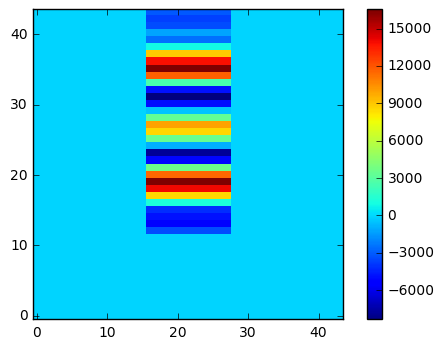

1131560.50413
1132045.16646
1132045.16646
1132168.48003
1132168.48003
1132199.44267
1132199.44267
1132207.19172
1132207.19172
1132209.12951
1132209.12951
1132209.61399
1132209.61399
1132209.73511
1132209.73511
1132209.76539
1132209.76539
1132209.77296
1132209.77296
1132209.77486


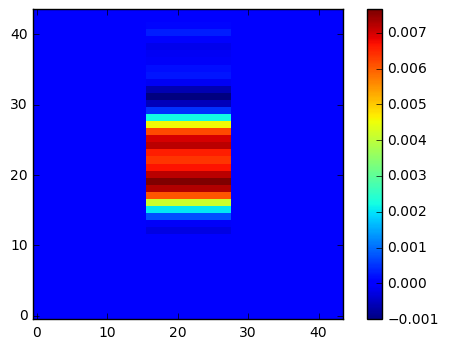

100%|██████████| 1000/1000 [00:20<00:00, 48.25it/s]


2


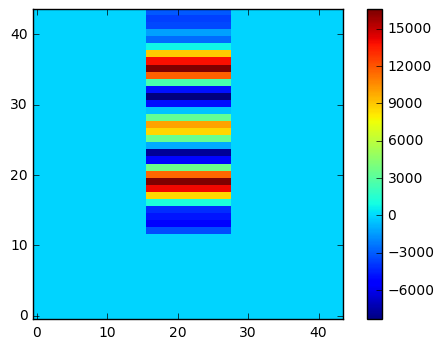

1132189.457
1132689.47714
1132689.47714
1132816.63027
1132816.63027
1132848.5528
1132848.5528
1132856.54183
1132856.54183
1132858.53961
1132858.53961
1132859.03909
1132859.03909
1132859.16396
1132859.16396
1132859.19518
1132859.19518
1132859.20298
1132859.20298
1132859.20493


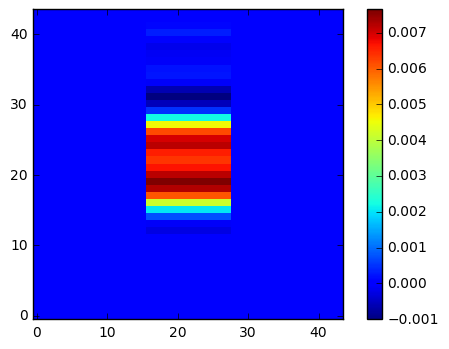

100%|██████████| 1000/1000 [00:17<00:00, 55.63it/s]


3


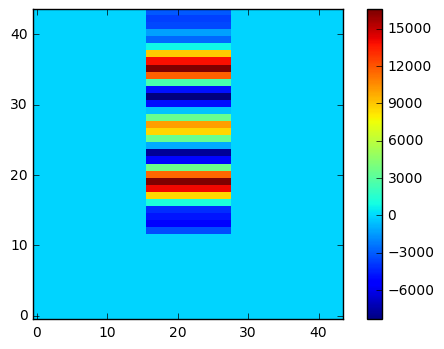

1132838.75015
1133354.13623
1133354.13623
1133485.13099
1133485.13099
1133518.01395
1133518.01395
1133526.24308
1133526.24308
1133528.30088
1133528.30088
1133528.81537
1133528.81537
1133528.94399
1133528.94399
1133528.97615
1133528.97615
1133528.98419
1133528.98419
1133528.9862


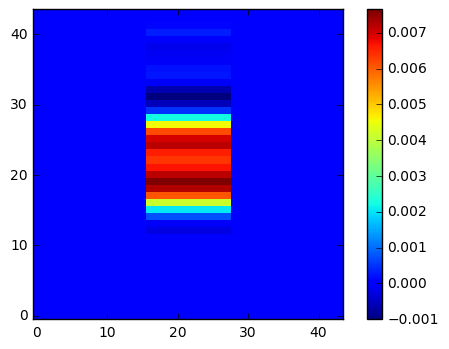

100%|██████████| 1000/1000 [00:17<00:00, 56.45it/s]


4


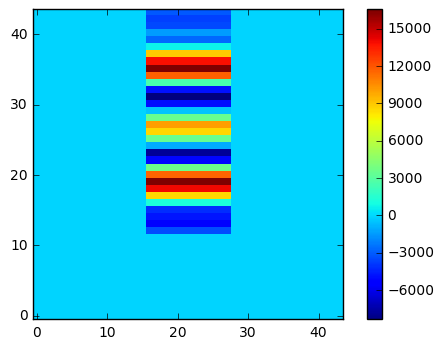

1133508.38567
1134039.14597
1134039.14597
1134173.98448
1134173.98448
1134207.82839
1134207.82839
1134216.29776
1134216.29776
1134218.41562
1134218.41562
1134218.94512
1134218.94512
1134219.0775
1134219.0775
1134219.11059
1134219.11059
1134219.11887
1134219.11887
1134219.12094


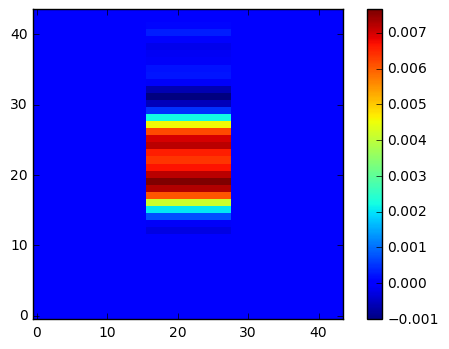

100%|██████████| 1000/1000 [00:18<00:00, 54.09it/s]


5


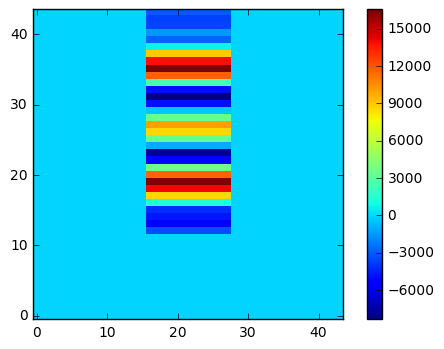

1134198.37401
1134744.51741
1134744.51741
1134883.20194
1134883.20194
1134918.00736
1134918.00736
1134926.71711
1134926.71711
1134928.89507
1134928.89507
1134929.4396
1134929.4396
1134929.57573
1134929.57573
1134929.60976
1134929.60976
1134929.61827
1134929.61827
1134929.6204


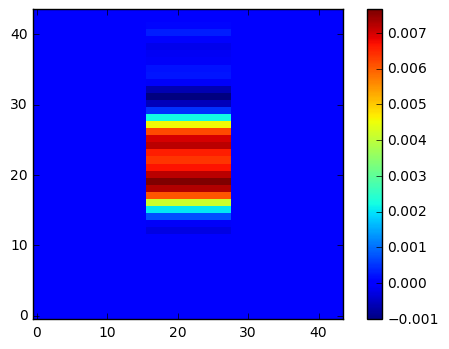

 13%|█▎        | 133/1000 [00:03<00:16, 52.92it/s]


KeyboardInterrupt: 

In [1333]:
for j in range(10):
    print(j)
    
    results = np.array(results)
    gds = gradient_descent_ds(gds, detector, (results[:, 0], results[:,1], results[:, 2]))
    
    plt.imshow(gds, origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.show()

    f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]
    
    results = []
    lnlike = []
    for i in tqdm(range(1000)):
        logL = lnlikelihood(data=tpf[i])
        sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, detector), method='Powell')
        results.append(sol.x)
        lnlike.append(sol.fun)
    


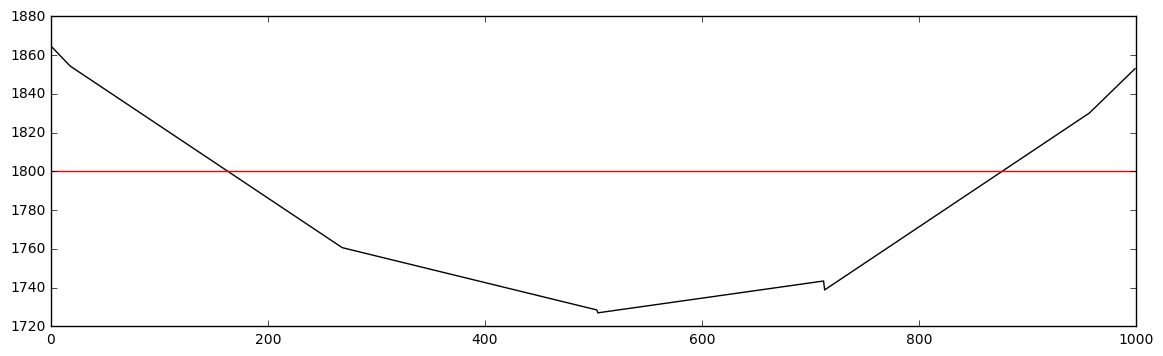

In [1334]:
pred_flux = [np.sum(model(f_n[i], yc_n[i], xc_n[i], gds)*16) for i in range(1000)] 

plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux, 'k')
plt.plot(np.arange(1000), np.sum(tpf, axis=(1,2)), 'r')
#plt.ylim(1690, 1900)